### Параметры



In [347]:
import numpy as np
from scipy.integrate import quad
from scipy import stats
import matplotlib.pyplot as plt
from scipy.interpolate import spline
%matplotlib inline

In [348]:
folder = 'pics/'

In [349]:
tau = 0.5
a = 0.7
b = 0.05
theta = a * b
sigma = 0.1
T_n = 30.
r_t = 0.05

In [350]:
def B(t, T):
    return (1 - np.e ** (- a * (T - t))) / a


def A(t, T):
    return np.e ** ((B(t, T) - (T - t)) * (theta / a - sigma ** 2 / (2 * a ** 2)) - sigma ** 2 * B(t, T) ** 2 / (4 * a))

In [351]:
def P(t, T):
    return A(t, T) * np.e ** (- r_t * B(t, T))

In [352]:
def libor(t, T1, T2):
    return (P(t, T1) - P(t, T2)) / (tau * P(t, T2))

In [353]:
def convexity_adj(t, T1, T2):
    
    I = (sigma**2 / a**2) * (1/(2*a) - 1/(2*a) * np.e ** (-2*a*(T1-t)) -\
                           1/a * np.e**(-a*(T2-T1)) + 1/(a) * np.e**(-a*(T1+T2) + 2*a*t) + \
                           1/(2*a) * np.e**(-2*a*(T2-T1)) - 1/(2*a) * np.e**(-2*a*(T2-t))) 
                           
    return ((P(t, T2) / (tau * P(t, T1))) * ((P(t, T1) / P(t, T2))**2 * np.e ** I - 2 * (P(t, T1) / P(t, T2)) + 1) + \
                            libor(t, T1, T2) * (P(t, T2) - P(t, T1)) / P(t, T1))

In [354]:
def convexity_adj_earl(t, T1, Te, T2):
    
    I = (sigma**2 / a**2) * 1/(2*a) * (np.e**(-a*(T1-Te)) - np.e**(-a*(T1+Te-2*t)) - np.e**(-a*(T2-Te)) + \
                                       np.e**(-a*(T2+Te-2*t)) - np.e**(-a*(T1+T2-2*Te)) + np.e**(-a*(T1+T2-2*t)) + \
                                       np.e**(-2*a*(T2-Te)) - np.e**(-2*a*(T2-t)))
    
    return libor(t, T1, T2) * (P(t, T2)-P(t, Te)) / P(t, Te) + \
           P(t, T2)/(P(t, Te)*tau) * (P(t, T1)*P(t, Te)/(P(t, T2)*P(t, T2))*np.e**I - P(t, T1)/P(t, T2) - P(t, Te)/P(t, T2) + 1)                       

In [355]:
def convexity_adj_later(t, T1, Tl, T2):
    
    I = (sigma**2 / a**2) * 1/(2*a) * (np.e**(-a*(Tl-T1)) - np.e**(-a*(T1+Tl-2*t)) - np.e**(-a*(T2-T1)) + \
                                       np.e**(-a*(T1+T2-2*t)) - np.e**(-a*(T2+Tl-2*T1)) + np.e**(-a*(T2+Tl-2*t)) + \
                                       np.e**(-2*a*(T2-T1))-np.e**(-2*a*(T2-t)))
    
    return libor(t, T1, T2) * (P(t, T2)-P(t, Tl)) / P(t, Tl) + \
           P(t, T2)/(P(t, Tl)*tau) * (P(t, T1)*P(t, Tl)/(P(t, T2)*P(t, T2))*np.e**I - P(t, T1)/P(t, T2) - P(t, Tl)/P(t, T2) + 1)
    
    

In [356]:
def convexity_after_T2(t, Tl, T1, T2):
    
    I = (sigma**2 / a**2) * 1/(2*a) * (np.e**(-a*(Tl-T1)) - np.e**(-a*(T1+Tl-2*t)) - np.e**(-a*(T2-T1)) + \
                                       np.e**(-a*(T1+T2-2*t)) - np.e**(-a*(T2+Tl-2*T1)) + np.e**(-a*(T2+Tl-2*t)) + \
                                       np.e**(-2*a*(T2-T1))-np.e**(-2*a*(T2-t)))
    
    return P(t, T2)/(P(t, Tl)*tau) * (P(t, Tl)/P(t, T2)*P(t, T1)/P(t,T2)*np.e**I - P(t, Tl)/P(t,T2)) - libor(t, T1, T2)

In [357]:
0.7**2

0.48999999999999994

In [358]:
T = np.arange(0, T_n, tau)

In [359]:
tau * P(0, 1.5) / ( P(0, 1))

0.48850002112458846

In [360]:
t=0.0
T1=0.0
T2=0.5
I = sigma**2 / a**2 * (1/(2*a) - 1/(2*a) * np.e ** (-2*a*(T1-t)) -\
                           1/a * np.e**(-a*(T2-T1)) + 1/(2*a) * np.e**(-a*(T1+T2) + 2*a*t) + \
                           1/(2*a) * np.e**(-2*a*(T2-T1)) - 1/(2*a) * np.e**(-2*a*(T2-t)))

In [361]:
((P(t, T1) / P(t, T2))**2 * np.e**(3 * I) - 2 * (P(t, T1) / P(t, T2)) + 1) * P(t, T1)

-0.031260385421041814

In [362]:
(P(t, T1) / P(t, T2)) ** 2 * np.e**I

1.0401910975867603

In [363]:
np.e**I

0.9897801599858889

In [364]:
convexity1 = np.zeros(len(T))
convexity2 = np.zeros(len(T))
convexity_earl = np.zeros(len(T))
convexity_later = np.zeros(len(T))
convexity_after = np.zeros(len(T))
libor1 = np.zeros(len(T))
for i in np.arange(len(T)-1):
    convexity1[i] = convexity_adj(0, T[i], T[i+1])
    convexity_earl[i] = convexity_adj_earl(0, T[i], T[i]-0.5, T[i+1])
    convexity_later[i] = convexity_adj_later(0, T[i], T[i]+0.2, T[i+1])
    libor1[i] = libor(0, T[i], T[i+1])
    convexity_after[i] = convexity_after_T2(0, T[i+1] + 0.2, T[i], T[i+1])
    
    
b = 0.5
theta = a * b

convexity2 = np.zeros(len(T))
for i in np.arange(len(T)-1):
    convexity2[i] = convexity_adj(0, T[i], T[i+1])    

C:\Users\THINK\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
C:\Users\THINK\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\THINK\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  after removing the cwd from sys.path.
C:\Users\THINK\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """
C:\Users\THINK\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline

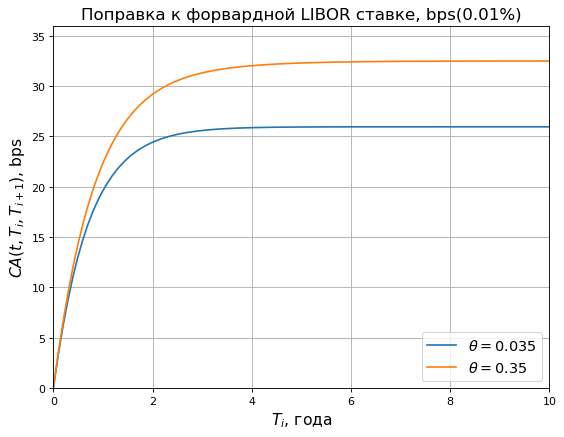

In [365]:
T_new = np.linspace(T.min(), T.max(), 300)
conv1_smooth = spline(T, convexity1, T_new)
conv2_smooth = spline(T, convexity2, T_new)
conv_earl_smooth = spline(T, convexity_earl, T_new)
conv_later_smooth = spline(T, convexity_later, T_new)
libor_smooth = spline(T, libor1, T_new)

fig = plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(T_new, conv1_smooth * 10000, label='$\\theta = 0.035$')
plt.plot(T_new, conv2_smooth * 10000, label='$\\theta = 0.35$')
plt.legend(prop={'size':13})
plt.axis([0, 10, 0, 36])
plt.grid(True)
plt.title(u'Поправка к форвардной LIBOR ставке, bps(0.01%)', fontsize=15)
plt.ylabel('$CA(t, T_i, T_{i+1})$, bps', fontsize=14)
plt.xlabel(u'$T_i$, года', fontsize=14)
plt.show()

fig.savefig(folder + 'conv-adj.png', dpi=fig.dpi, transparent=True)

In [366]:
b_floor = 0.01
b_ceil = 2
th = np.linspace(a*b_floor, a*b_ceil, 10000)
convexity_theta = np.zeros(len(th))
T1 = 5
T2 = T1 + tau
for i in np.arange(len(th)):
    theta = th[i]
    convexity_theta[i] = convexity_adj(0, T1, T2)

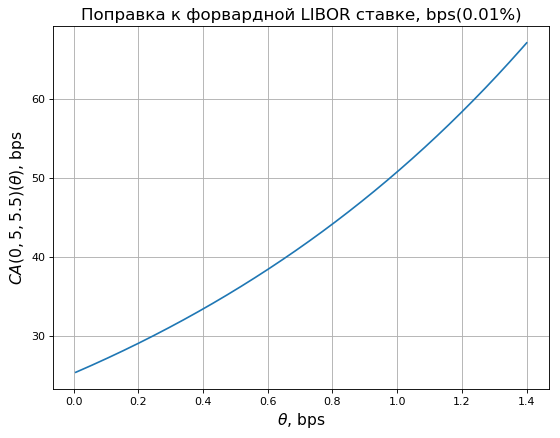

In [367]:
fig = plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(th, convexity_theta * 10000)
# plt.legend(prop={'size':13})
# plt.axis([0, 10, 0, 36])
plt.grid(True)
plt.title(u'Поправка к форвардной LIBOR ставке, bps(0.01%)', fontsize=15)
plt.ylabel('$CA(0, 5, 5.5)(\\theta)$, bps', fontsize=14)
plt.xlabel(u'$\\theta$, bps', fontsize=14)
plt.show()

fig.savefig(folder + 'conv-adj-mean_rev.png', dpi=fig.dpi, transparent=True)

C:\Users\THINK\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
C:\Users\THINK\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\THINK\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  after removing the cwd from sys.path.
C:\Users\THINK\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """
C:\Users\THINK\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline

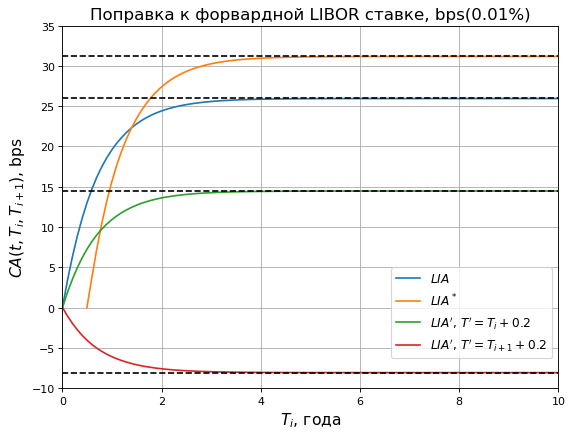

In [368]:
T_new = np.linspace(T.min(), T.max(), 300)
conv1_smooth = spline(T, convexity1, T_new)
conv2_smooth = spline(T, convexity2, T_new)
conv_earl_smooth = spline(T[1:], convexity_earl[1:], T_new[5:])
conv_later_smooth = spline(T, convexity_later, T_new)
conv_after_smooth = spline(T, convexity_after, T_new)
libor_smooth = spline(T, libor1, T_new)

fig = plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(T_new, conv1_smooth*10000, label='$LIA$')
plt.plot(T_new[5:], conv_earl_smooth*10000, label='$LIA^*$')
plt.plot(T_new, conv_later_smooth*10000, label='$LIA\'$, $T\'=T_{i}+0.2$')
plt.plot(T_new, conv_after_smooth*10000, label='$LIA\'$, $T\'=T_{i+1}+0.2$')
# plt.plot(T_new, libor_smooth, label='$libor$')
# plt.axvline(x=0.5)
plt.legend(prop={'size':11}, bbox_to_anchor=(1, 0.35))
plt.axis([0, 10, -10, 35])
plt.grid(True)
plt.title(u'Поправка к форвардной LIBOR ставке, bps(0.01%)', fontsize=15)
plt.ylabel('$CA(t, T_i, T_{i+1})$, bps', fontsize=14)
plt.xlabel(u'$T_i$, года', fontsize=14)

plt.axhline(25.99, c='black', ls='--')
plt.axhline(31.228, c='black', ls='--')
plt.axhline(14.48, c='black', ls='--')
plt.axhline(-8.096, c='black', ls='--')

plt.show()

fig.savefig(folder + 'conv-adj_comp.png', dpi=fig.dpi, transparent=True)

In [369]:
b=0.05
print libor(0, 0.5, 1)
print libor(0, 0.5, 1) + convexity_adj(0, 0.5, 1)
print libor(0, 0.5, 1) + convexity_adj_earl(0, 0.5, 0.4, 1)
print libor(0, 0.5, 1) + convexity_adj_later(0, 0.5, 0.6, 1)

1.0421828492246603
1.0441303964161879
1.0439790304630698
1.0436844316249698


In [370]:
print convexity_adj(0, 0.5, 1)
print convexity_adj_earl(0, 0.5, 0.3, 1)

0.001947547191527621
0.0015129123267547673


In [371]:
print libor(0, 0, 0.5)
print libor(0, 0, 0.5) + convexity_adj_earl(-0.2, 0, -0.2, 0.5)
print libor(0, 0, 0.5) + convexity_adj(0, 0, 0.5)

0.3877010658531316
0.3877010658531316
0.3877010658531316


$\tau$

In [372]:
convexity_adj_earl(0, 0.5, 0.4, 1)

0.0017961812384094666

In [373]:
T1=0
T2=0.5
t=0
I = sigma**2 / a**2 * (1/(2 *a) - 1/(2*a) * np.e ** (-2*a*(T1-t)) -\
                           1/a * np.e**(-a*(T2-T1)) + 1/a * np.e**(-a*(T1+T2) + 2*a*t)) + \
                           1/(2*a) * np.e**(-2*a*(T2-T1)) - 1/(2*a) * np.e**(-2*a*(T2-t)) 
print np.e**I

1.0


In [374]:
(P(0, 5) - P(0, 6)) / P(0, 6)

6.013846190230371

In [375]:
2.**2/3.**2


0.4444444444444444

In [376]:
4 / 9.

0.4444444444444444

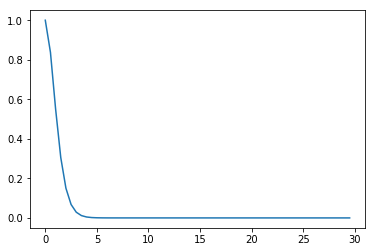

In [377]:
plt.plot(T, P(0, T))
plt.show()

### Асимптотики

In [378]:
tau = 0.5
a = 0.7
b = 0.05
theta = a * b
sigma = 0.1
T_n = 30.
r_t = 0.05

in-arrears

In [379]:
limP1 = np.e**((theta/a - sigma**2/(2*a))*tau)
limP2 = np.e**(-(theta/a - sigma**2/(2*a))*tau)

limI = sigma**2/(a**2) * (1/(2*a) - 1/a*np.e**(-a*tau) + 1/(2*a)*np.e**(-2*a*tau))

asymp1 = 1/tau * ((limP1 - 1) * (limP2 - 1)) + 1/tau * limP2 * (limP1**2 * np.e**limI - 2*limP1 + 1)

print asymp1*10000

25.9926284101


До фиксинга

In [380]:
taus = 1
limP1 = np.e**((theta/a - sigma**2/(2*a))*tau)
limP2 = np.e**(-(theta/a - sigma**2/(2*a))*tau)
limPs1 = np.e**((theta/a - sigma**2/(2*a))*taus)
limPs2 = np.e**(-(theta/a - sigma**2/(2*a))*taus)

limIs = sigma**2/(2*a**3) * (np.e**(-a*0.5) - np.e**(-a*taus) - np.e**(-a*1.5) + np.e**(-2*a*taus))

asymp2 = 1/tau * ((limP1 - 1) * (limPs2 - 1)) + 1/tau * limPs2 * (limP1*limPs1 * np.e**limIs - limP1 - limPs1 + 1)

print asymp2*10000

31.2282488428


После фиксинга

In [381]:
taup = 0.3
limP1 = np.e**((theta/a - sigma**2/(2*a))*tau)
limP2 = np.e**(-(theta/a - sigma**2/(2*a))*tau)
limPp1 = np.e**((theta/a - sigma**2/(2*a))*taup)
limPp2 = np.e**(-(theta/a - sigma**2/(2*a))*taup)

limIp = sigma**2/(2*a**3) * (np.e**(-a* 0.2) - np.e**(-a*tau) - np.e**(-a*0.7) + np.e**(-2*a*tau))

asymp3 = 1/tau * ((limP1 - 1) * (limPp2 - 1)) + 1/tau * limPp2 * (limP1*limPp1 * np.e**limIp - limP1 - limPp1 + 1)

print asymp3*10000

14.4897857194


In [382]:
taup = 0.2
limP1 = np.e**((theta/a - sigma**2/(2*a))*tau)
limP2 = np.e**(-(theta/a - sigma**2/(2*a))*tau)
limPp1 = np.e**((theta/a - sigma**2/(2*a))*taup)
limPp2 = np.e**(-(theta/a - sigma**2/(2*a))*taup)

limIp = sigma**2/(2*a**3) * (np.e**(-a* 0.7) - np.e**(-a*tau) - np.e**(-a*1.2) + np.e**(-2*a*tau))

asymp3 = 1/tau * limPp1 * (limP1*limPp2 * np.e**limIp - limPp2) - 1/tau * (limP1-1)

print asymp3*10000

-8.09629021922
